<a href="https://colab.research.google.com/github/JulienGremillot/OpenClassrooms_Ingenieur_Machine_Learning/blob/main/P7%20-%20D%C3%A9veloppez%20une%20preuve%20de%20concept/D%C3%A9veloppez_une_preuve_de_concept_4_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,\
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation,\
    RandomContrast, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array,\
 ImageDataGenerator
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import tensorflow as tf

# Comme mon modèle est basé sur EfficientNet, j'utilise cette méthode
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
from google.colab import drive
drive._mount('/content/drive', force_remount=False)
os.chdir("/content/drive/MyDrive/Colab Notebooks")
print("Répertoire de travail courant : %s" % os.getcwd())

Mounted at /content/drive
Répertoire de travail courant : /content/drive/MyDrive/Colab Notebooks


In [ ]:
IMAGES_DIR_TREE = 'cars_ims_tree'  # répertoire arborescent généré
width, height = 224, 224
batch_size = 32
train = image_dataset_from_directory(
  IMAGES_DIR_TREE,
  validation_split=0.2,
  subset="training",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
val = image_dataset_from_directory(
  IMAGES_DIR_TREE,
  validation_split=0.2,
  subset="validation",
  seed=99,
  image_size=(height, width),
  batch_size=batch_size)
class_names = train.class_names
nb_classes = len(class_names)
print("Nombre de classes :", nb_classes)

Found 12488 files belonging to 196 classes.
Using 9991 files for training.
Found 12488 files belonging to 196 classes.
Using 2497 files for validation.
Nombre de classes : 196


In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal", input_shape=(height, width, 3)),
  RandomRotation(factor=0.4, fill_mode="wrap"),
  RandomZoom(0.2),
  RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="wrap"),
  RandomContrast(factor=0.2)
])

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet',
                            input_shape=(height, width, 3),
                            classes=nb_classes)
base_model.trainable = False
inputs = Input(shape=(height, width, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
class1 = Dense(1920, activation='relu')(x)
outputs = Dense(nb_classes, activation='softmax')(class1)
model = Model(inputs, outputs)
model.compile(optimizer=SGD(learning_rate=0.01),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model.fit(
  train,
  validation_data=val,
  epochs=50
)

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/50
313/313 [==============================] - 1749s 5s/step - loss: 5.2930 - accuracy: 0.0082 - val_loss: 5.2402 - val_accuracy: 0.0096
Epoch 2/50
313/313 [==============================] - 914s 3s/step - loss: 5.1842 - accuracy: 0.0202 - val_loss: 5.1705 - val_accuracy: 0.0200
Epoch 3/50
313/313 [==============================] - 936s 3s/step - loss: 5.0781 - accuracy: 0.0410 - val_loss: 5.0916 - val_accuracy: 0.0360
Epoch 4/50
313/313 [==============================] - 1047s 3s/step - loss: 4.9628 - accuracy: 0.0607 - val_loss: 4.9980 - val_accuracy: 0.0513
Epoch 5/50
313/313 [==============================] - 1051s 3s/step - loss: 4.8296 - accuracy: 0.0866 - val_loss: 4.8923 - val_accuracy: 0.0629
Epoch 6/50
313/313 [==============================] - 1066s 3s/step - loss: 4.6943 - accuracy: 0.1049 - val_loss: 4.7794 - val_accuracy: 0.0825
Epoch 7/50
313/313 [==============================] - 1044s 3s/step - los

In [ ]:
def show_perfs(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

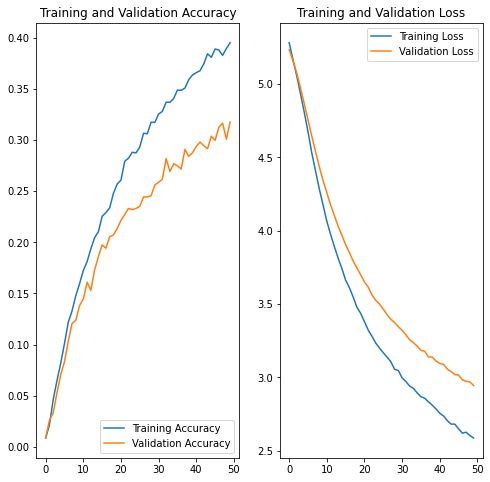

In [ ]:
show_perfs(history, 50)

In [ ]:
def get_top3(img):
  img_array = img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)  # batch d'une seule image
  img_preprocessed = preprocess_input(img_batch)  # normalisation
  prediction = model.predict(img_preprocessed)
  top_indices = prediction[0].argsort()[-3:][::-1]
  result = [class_names[i] for i in top_indices]
  result.sort(key=lambda x: x[2], reverse=True)
  return(result)

AM General Hummer SUV 2000 -> ['Jeep Wrangler SUV 2012', 'Jeep Patriot SUV 2012', 'AM General Hummer SUV 2000']
Acura RL Sedan 2012 -> ['Suzuki SX4 Sedan 2012', 'Honda Odyssey Minivan 2012', 'Dodge Caravan Minivan 1997']
Acura TL Sedan 2012 -> ['Acura RL Sedan 2012', 'Hyundai Veloster Hatchback 2012', 'Honda Odyssey Minivan 2012']
Acura TL Type-S 2008 -> ['Acura TL Type-S 2008', 'Acura TL Sedan 2012', 'Daewoo Nubira Wagon 2002']
Acura TSX Sedan 2012 -> ['Acura TL Sedan 2012', 'Dodge Challenger SRT8 2011', 'BMW ActiveHybrid 5 Sedan 2012']
Acura Integra Type R 2001 -> ['Bugatti Veyron 16.4 Coupe 2009', 'Dodge Challenger SRT8 2011', 'BMW Z4 Convertible 2012']
Acura ZDX Hatchback 2012 -> ['Plymouth Neon Coupe 1999', 'Chevrolet Impala Sedan 2007', 'Chevrolet Malibu Sedan 2007']
Aston Martin V8 Vantage Convertible 2012 -> ['Aston Martin Virage Convertible 2012', 'Chrysler Crossfire Convertible 2008', 'Chrysler PT Cruiser Convertible 2008']
Aston Martin V8 Vantage Coupe 2012 -> ['Acura TL Typ

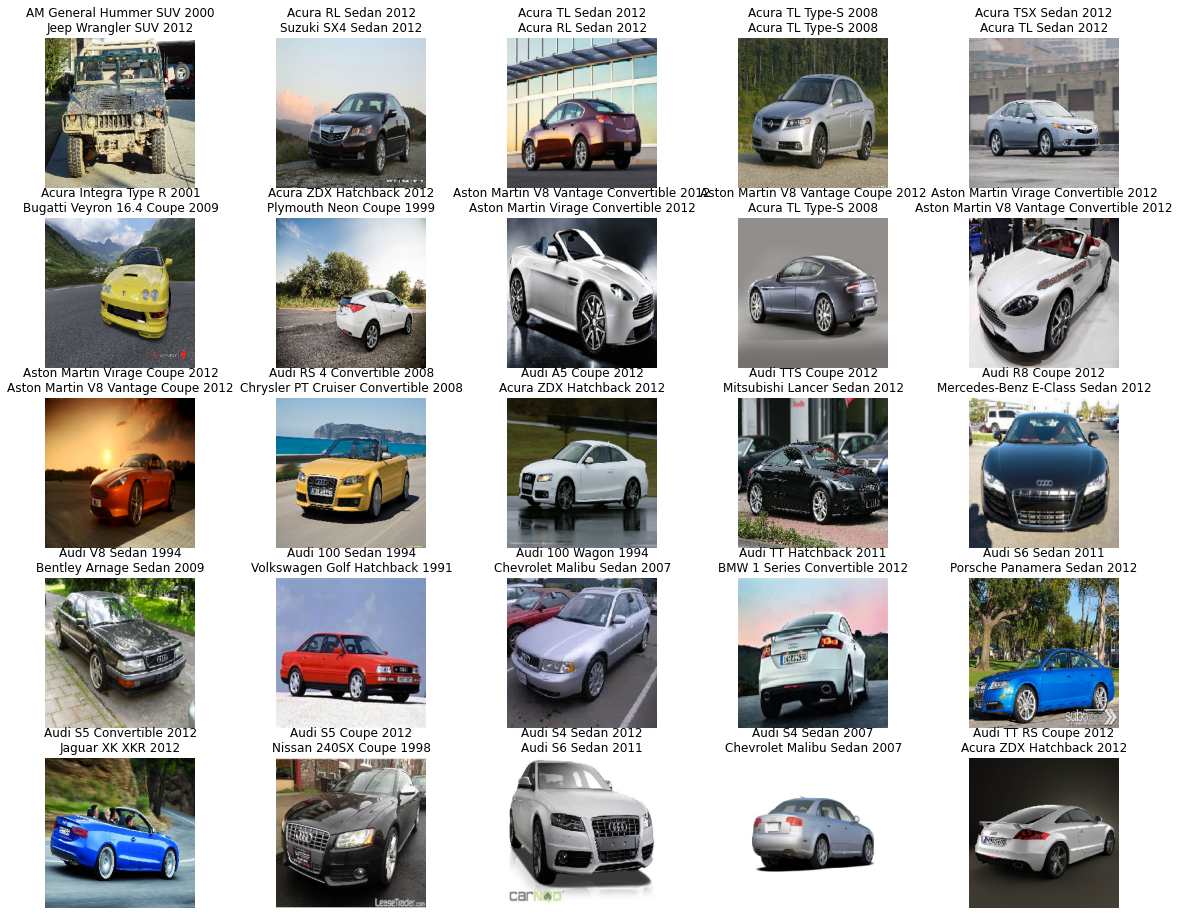

In [ ]:
TEST_DIR_TREE = 'cars_test_tree'  # répertoire de test arborescent généré
plt.figure(figsize=(20,16))
i = 1
for sub_dir in os.listdir(TEST_DIR_TREE):
    sub_dir_images = os.listdir(os.path.join(TEST_DIR_TREE, sub_dir))
    j = 0
    for sub_dir_image in sub_dir_images:
        if i <= 25 and j == 0:
            img_path = os.path.join(TEST_DIR_TREE, sub_dir, sub_dir_image)
            img = load_img(img_path, target_size=(224, 224))
            plt.subplot(5, 5, i)
            plt.axis('off')
            predictions = get_top3(img)
            print(sub_dir, '->', predictions)
            plt.title(sub_dir + "\n" + predictions[0])
            plt.imshow(img)
            i = i + 1
            j = j + 1
plt.show()